In [1]:
import numpy as np
from scipy import stats
import scipy.io
from matplotlib import pyplot as plt
import pstats

In [2]:
# Message Passing on Single Node
# G: non-symmetric social networks
# Y: evidence, observed data
# T: num. of iterations
# X: used for test

def AEMBP_GCHMM(G,Y,C, sC, initial, MaxIter, tol,X, prior={'xi': 0.25, 'alpha':0.1, 'beta':0.1, 'gamma':0.5, 
                                                  'theta_1':0.75, 'theta_0':0.25, 'ax':2, 'bx':5, 
                                                  'aa':2, 'ba':5, 'ab':2,'bb':5, 'ar':2, 'br':5,
                                                  'al':2,'bl':2,'a0':2,'b0':5}):
    Xr = X
    N, _, D = G.shape # N*N*D
    _, S, _ = Y.shape # N*S*D

    for i in range(D):
        Gt = G[:,:,i]
        G[:,:,i] = np.eye(N) + (Gt+Gt.T)>0        

    # Initialization
    if initial == 'f':
        # A good trial
        xi = prior['xi']; alpha = prior['alpha']
        beta = prior['beta']; gamma = prior['gamma']
        theta1 = prior.get("theta_1")*np.ones((1,S))
        theta0 = prior.get("theta_0")*np.ones((1,S))
    else:
        # Initial by random sampling, has a chance to fail
        ax=prior['ax']; bx=prior['bx'] 
        aa=prior['aa']; ba=prior['ba'] 
        ab=prior['ab']; bb=prior['bb'] 
        ar=prior['ar']; br=prior['br']
        a1=prior['al']; b1=prior['bl'] 
        a0=prior['a0']; b0=prior['b0']

        xi = stats.beta.rvs(ax, bx, size=1)
        alpha = stats.beta.rvs(aa, ba, size=1)
        beta = stats.beta.rvs(ab, bb, size=1)
        gamma = stats.beta.rvs(ar,br, size=1)
        theta1 = stats.beta.rvs(a1,b1,size=(1,S)) 
        theta0 = stats.beta.rvs(a0,b0,size=(1,S))

    para = np.c_[xi, alpha, beta, gamma, theta1, theta0]
    #print(para)

    # Construct Belief of each X
    PX = np.zeros((N,2,D+1))
    PX[:,:,0] = np.hstack(((1-xi)*np.ones((N,1)), xi*np.ones((N,1)))) # Root node X(0): N x 2
    
    LX = np.zeros((N,2,D+1))

    # Construct Message between X
    PXX = np.ones((N,N,2,D))
    LXX = np.ones((N,N,2,D))

    # Iteration
    for T in range(MaxIter): 
        #print(T)
        para1 = para
        
        f0 = lambda u: (1-beta)**u;
        f1 = lambda u: 1-(1-alpha)*(1-beta)**u
    # Expectation
        # Update PX,LX,BEL  
        LX[:,:,0] = np.hstack((np.prod(LXX[:,:,0,0],1)[:, None], np.prod(LXX[:,:,1,0],1)[:, None]))

        for i in range(1,D):
            PX[:,:,i] = fGX(G[:,:,i-1], PXX[:,:,:,i-1], alpha, gamma, C, sC, f0, f1)
            LX[:,:,i] = np.hstack((fYX(Y[:,:,i-1], theta0) * np.prod(LXX[:,:,0,i],1)[:, None],
                              fYX(Y[:,:,i-1], theta1) * np.prod(LXX[:,:,1,i],1)[:, None]))
        PX[:,:,D] = fGX(G[:,:,D-1], PXX[:,:,:,D-1], alpha, gamma, C, sC, f0, f1)
        LX[:,:,D] = np.hstack((fYX(Y[:,:,D-1],theta0), fYX(Y[:,:,D-1], theta1)))

        BEL = PX*LX
        BEL = BEL/np.sum(BEL,1,keepdims=True)
        #BEL = bsxfun(@rdivide,BEL,np.sum(BEL,1)) #normalization

    # test sesseion
        tmpbel = np.transpose(BEL, axes = [0, 2, 1])
        xpred = tmpbel[:,:,1] > tmpbel[:,:,0]
        
        acc = np.sum(xpred==Xr) / N / (D+1);

    
        LXX1 = LXX
        for i in range(D):
            # Update LXX
            tp0 = np.sum(LX[:,:,i+1]*np.hstack(((1-alpha)*SumProd(G[:,:,i],PXX[:,:,:,i],f0,C,sC),SumProd(G[:,:,i],PXX[:,:,:,i],f1,C,sC))), 1)
            tp1 = (LX[:,:,i+1] @ np.vstack((gamma,1-gamma))).reshape(-1)
            LXX[:,:,0,i] = LXX[:,:,0,i] * (1-np.eye(N)) + np.diag(tp0 / (tp0+tp1))
            LXX[:,:,1,i] = LXX[:,:,1,i] * (1-np.eye(N)) + np.diag(tp1 / (tp0+tp1))
                           
            Gt = G[:,:,i] - np.eye(N)
            for j in range(N):
                ind = np.where(Gt[j,:]==1)[0]
                for k in range(len(ind)):
                    if len(ind)==1:
                        temp0 = LX[j,0,i+1] * (gamma*PXX[j,j,1,i] + (1-alpha)*PXX[j,j,0,i]) + LX[j,1,i+1] * ((1-gamma)*PXX[j,j,1,i] + alpha*PXX[j,j,0,i])
                        temp1 = LX[j,0,i+1] * (gamma*PXX[j,j,1,i] + (1-alpha)*(1-beta)*PXX[j,j,0,i]) + LX[j,1,i+1] * ((1-gamma)*PXX[j,j,1,i]+(1-(1-alpha)*(1-beta))*PXX[j,j,0,i])
                    else:
                        temp0 = LX[j,0,i+1] * (gamma*PXX[j,j,1,i] + (1-alpha)*PXX[j,j,0,i]*sp(0,Gt[j,:],ind[k],PXX[j:(j+1),:,:,i],f0,C[int(np.sum(Gt[j,:]))-2][0], sC[int(np.sum(Gt[j,:]))-2][0])) + LX[j,1,i+1]*((1-gamma)*PXX[j,j,1,i] + PXX[j,j,0,i]*sp(0, Gt[j,:], ind[k], PXX[j:(j+1),:,:,i], f1, C[int(np.sum(Gt[j,:]))-2][0], sC[int(np.sum(Gt[j,:]))-2][0]))                      
                        temp1 = LX[j,0,i+1] * (gamma*PXX[j,j,1,i] + (1-alpha)*PXX[j,j,0,i]*sp(1,Gt[j,:],ind[k],PXX[j:(j+1),:,:,i],f0,C[int(np.sum(Gt[j,:]))-2][0], sC[int(np.sum(Gt[j,:]))-2][0])) + LX[j,1,i+1]*((1-gamma)*PXX[j,j,1,i] + PXX[j,j,0,i]*sp(1, Gt[j,:], ind[k], PXX[j:(j+1),:,:,i], f1, C[int(np.sum(Gt[j,:]))-2][0], sC[int(np.sum(Gt[j,:]))-2][0]))
                    LXX[j,ind[k],0,i] = temp0/(temp0+temp1)
                    LXX[j,ind[k],1,i] = temp1/(temp0+temp1)
            
            # Update PXX
            tmp0 = BEL[:,0,i] / LXX1[:,:,0,i]
            tmp1 = BEL[:,1,i] / LXX1[:,:,1,i]
            tmp0[np.isnan(tmp0)] = 0
            tmp1[np.isnan(tmp1)] = 0
            tmp = tmp0 + tmp1
            
            # normalization
            tmp0 = tmp0 / tmp  
            tmp1 = tmp1 / tmp 
            
            tmp0[G[:,:,i]==0] = 1
            tmp1[G[:,:,i]==0] = 1
            PXX[:,:,0,i] = tmp0
            PXX[:,:,1,i] = tmp1
    # Approximate Maximization
        Xpred = np.transpose(BEL,axes =[0,2,1])
        X = 0 + (Xpred[:,:,1] > Xpred[:,:,0])
        # Num. of previous infection
        NPI = NumPreInf(X,G) 
    
        xi = np.sum(X[:,0]) / N
        gamma = np.sum((X[:,0:D]==1)*(X[:,1:]==0))/np.sum(X[:,0:D]==1)
        alpha = np.sum((X[:,0:D]==0)*X[:,1:]*(NPI==0))/np.sum((X[:,0:D]==0)*(NPI==0))
        beta = UpdateBeta(NPI, X, alpha)
        temp = np.transpose(np.repeat(np.expand_dims(X[:,1:], axis=2),
                                      S, axis = 2), axes = [0, 2, 1])
        theta1 = np.sum(Y * temp, axis = (0, 2)) / np.sum(temp, axis = (0, 2)).reshape((1, S))
        theta0 = np.sum(Y * (temp == 0), axis = (0, 2)) / np.sum((temp == 0), axis = (0, 2)).reshape((1, S))
    
    # Convergence
        para = np.c_[xi, alpha, beta, gamma, theta1, theta0]

        diff = para1 - para
        if np.max(diff) < tol:
            break
    return [BEL, para]

In [3]:
# Yt is a matrix
def fYX(Yt,theta):
#compute the message from Y->X
    L = np.prod((Yt * theta + (1-Yt) * (1-theta)),1, keepdims=True)
    return(L)

In [4]:
def fGX(Gt,PXXt,a,r,C,sC,f0,f1):
# compute the belief from parent
    tmp0 = (r * np.diag(PXXt[:,:,1]))[:,None] + ((1-a)*np.diag(PXXt[:,:,0]))[:,None] * SumProd(Gt,PXXt,f0,C,sC)
    tmp1 = ((1-r) * np.diag(PXXt[:,:,1]))[:,None] + (np.diag(PXXt[:,:,0]))[:,None] * SumProd(Gt,PXXt,f1,C,sC)
    P = np.hstack((tmp0,tmp1))
    return(P)

In [5]:
def SumProd(Gtt,PXXt,fun,C,sC):
# compute the form: \sum fun(...) \prod f_i
    Gt = Gtt.copy()
    N, _ = Gt.shape
    Gt = Gt - np.eye(N)
    cnt = np.sum(Gt,1)
    res = np.zeros((N,1))#
    for i in range(N):
        k = int(cnt[i])
        if k == 0:
            res[i] = 1
            continue
        tmp = PXXt[i:(i+1), Gt[i,:]==1,:]
        tmp0 = np.matlib.repmat(tmp[:,:,0],2**k,1) #np.kron(np.ones((2**k,1)),tmp[:,:,0]) # np.matlib.repmat(tmp[:,:,0],2**k,1) #np.tile(tmp[:,:,0], [2**k,1]) 
        tmp10 = np.matlib.repmat(tmp[:,:,1]-tmp[:,:,0],2**k,1) #np.kron(np.ones((2**k,1)),tmp[:,:,1]) #np.matlib.repmat(tmp[:,:,1],2**k,1) #np.tile(tmp[:,:,1], [2**k,1])
        res[i] = np.sum(fun(sC[k-1]) * np.prod(C[k-1][0]*tmp10+tmp0,1))
    return(res)

In [6]:
def sp(x,Gjt,indk,P,fun,Ck,sCk):
# compute sum product
    Gtj = Gjt.copy()
    Gtj[indk] = 0 
    tmp = P[0:1, Gtj==1, :]
    H, _ = Ck.shape
    tmp0 =np.matlib.repmat(tmp[:,:,0],H,1)  #np.kron(np.ones((H,1)),tmp[:,:,0]) # np.tile(tmp[:,:,0], [H,1])
    tmp10 = np.matlib.repmat(tmp[:,:,1]-tmp[:,:,0],H,1) #np.kron(np.ones((H,1)),tmp[:,:,1]) # np.tile(tmp[:,:,1], [H,1])
    #print(P.shape, tmp.shape, H, Ck.shape, tmp0.shape, tmp1.shape)
    res = np.sum(fun(x + sCk) * np.prod(Ck*tmp10+tmp0,1))
    return(res)


In [7]:
def NumPreInf(X,G):
# compute the number of connected nodes = 1 at previous timestamp
    N, _, D = G.shape
    NPI = np.zeros((N,D)) # Num. of previous infection
    for i in range(D):
        Gt = G[:,:,i] - np.eye(N);
        Xt = X[:,i]
        tmp = (Gt + Gt.T)>0
        NPI[:,i] = tmp @ Xt
    return(NPI)

In [8]:
def UpdateBeta(NPI,X,alpha):
    _, D = NPI.shape
    #mcnt = max(NPI.ravel())
    mcnt = int(np.max(NPI))
    B = np.zeros((mcnt,1))
    for i in range(mcnt):
        tmp = np.sum((X[:,0:D]==0)*(X[:,1:D+1]==0)*(NPI==(i+1))) / np.sum((X[:,0:D]==0)*(NPI==(i+1)))
        B[i] = min(np.power(tmp/(1-alpha),(1/(i+1))), 1)
    beta = 1 - np.mean(B)
    return(beta)

In [9]:
## Load synthesized data
Y = scipy.io.loadmat('Y.mat')['Y'] # Graph information of contacts each timestamp, dim=(84,84,107)
X = scipy.io.loadmat('X.mat')['X'] # Hidden(infection) states, dim=(84,108), including X(0)
G = scipy.io.loadmat('G.mat')['G'] # Observed(symptom) states, dim=(84,6,107)
C = scipy.io.loadmat('C.mat')['C']

sC = [np.sum(c[0], 1) for c in C]

In [ ]:
[XBELEM, paraAEM] = AEMBP_GCHMM(G,Y,C, sC, 'f', 10, 0.0001,X)

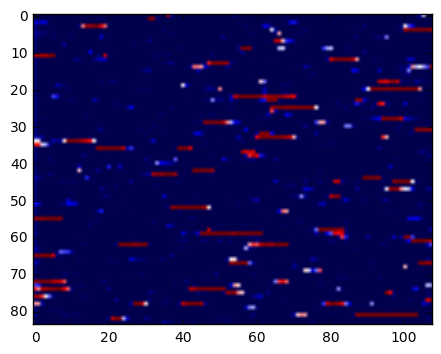

In [32]:
plt.imshow(XBELEM[:,1,:], cmap='seismic')
plt.savefig("predicted_AEM.png", dpi = 300, bbox_inches ="tight")

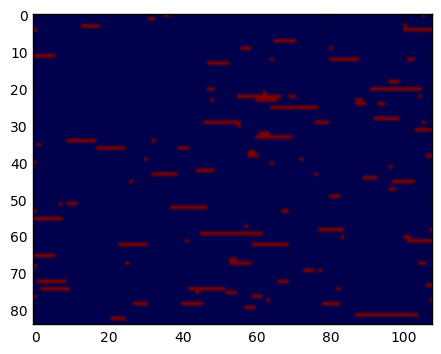

In [30]:
plt.imshow(X, cmap='seismic')
plt.savefig("true.png", dpi = 300, bbox_inches ="tight")

In [10]:
def work(G,Y,C, sC, initial, MaxIter, tol,X):
    AEMBP_GCHMM(G,Y,C, sC, initial, MaxIter, tol,X)

In [11]:
%prun -q -D AEMBP_GCHMM.prof AEMBP_GCHMM(G, Y, C, sC,'f', 5, 0.0001, X)

 
*** Profile stats marshalled to file 'AEMBP_GCHMM.prof'. 


In [13]:
p = pstats.Stats('AEMBP_GCHMM.prof')
p.sort_stats('time','cumulative').print_stats(15)
pass

Mon May  1 13:39:50 2017    AEMBP_GCHMM.prof

         24109445 function calls in 52.915 seconds

   Ordered by: internal time, cumulative time
   List reduced from 66 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   576640   14.303    0.000   31.654    0.000 <ipython-input-6-347b45838ca2>:1(sp)
  2658791    7.131    0.000    7.131    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    5.619    5.619   52.914   52.914 <ipython-input-2-d8846caa74c5>:7(AEMBP_GCHMM)
  1500600    4.340    0.000   11.701    0.000 /opt/conda/lib/python3.5/site-packages/numpy/matlib.py:310(repmat)
     2140    4.190    0.002   10.294    0.005 <ipython-input-5-49c0020f5080>:1(SumProd)
  3001205    3.610    0.000    3.610    0.000 {method 'repeat' of 'numpy.ndarray' objects}
  1906336    3.290    0.000    8.949    0.000 /opt/conda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:1743(sum)
  4503420    2.051    0.000    2.051    0.000 {metho